<a href="https://colab.research.google.com/github/tsaialice9/HW1_VAE_MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets, transforms

# 定義轉換：把圖片轉成 tensor
transform = transforms.ToTensor()

# 自動下載 MNIST 到 ./data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 35.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.88MB/s]


In [2]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [3]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [5]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}, Average loss: {train_loss / len(train_loader.dataset):.4f}")

for epoch in range(1, 11):
    train(epoch)


Epoch 1, Average loss: 165.6204
Epoch 2, Average loss: 122.1090
Epoch 3, Average loss: 115.0008
Epoch 4, Average loss: 111.9946
Epoch 5, Average loss: 110.2957
Epoch 6, Average loss: 109.1761
Epoch 7, Average loss: 108.2841
Epoch 8, Average loss: 107.6104
Epoch 9, Average loss: 107.1034
Epoch 10, Average loss: 106.7070


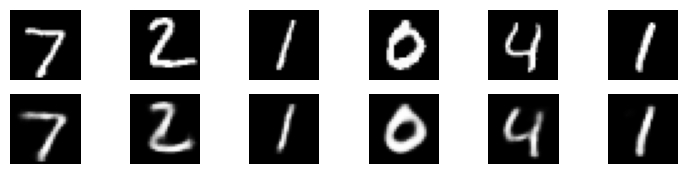

In [6]:
import matplotlib.pyplot as plt

def test_and_show():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)

        plt.figure(figsize=(9, 2))
        for i in range(6):
            # 原始圖片
            plt.subplot(2, 6, i+1)
            plt.imshow(data[i][0].cpu(), cmap="gray")
            plt.axis("off")
            # 重建圖片
            plt.subplot(2, 6, i+7)
            plt.imshow(recon[i].view(28, 28).cpu(), cmap="gray")
            plt.axis("off")
        plt.show()

test_and_show()
